In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from collections import Counter

from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from yellowbrick.classifier import ClassificationReport

from google.colab import drive
from __future__ import print_function

### Load data

In [ ]:
drive.mount("/content/drive")
df1 = pd.read_csv('./drive/MyDrive/Data/car_merged.csv',delimiter=',', skipinitialspace=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df1.head()

,Hour_Start,Hour_End,SOC_Start,SOC_End,day_name,day_type,Model,vehicle_model,duration,distance,...,SOC_End_charge,charge_level,vehicle_name,year,month,day,charge_after,charge_start_time,charge_end_time,Hour
0,1424,1438,59.756098,52.804878,Tuesday,weekday,Leaf,Leaf 24,814.56,4.459798,...,100,LEVEL_1,P_1001,2015,6,16,1,2015/06/16 14:41,2015/06/17 1:32,14
1,613,641,100.000000,76.341463,Wednesday,weekday,Leaf,Leaf 24,1679.41,20.450966,...,No,None,P_1001,2015,6,17,0,NaN,NaN,6
2,1629,1702,76.341463,49.634146,Wednesday,weekday,Leaf,Leaf 24,1989.65,19.825535,...,100,LEVEL_1,P_1001,2015,6,17,1,2015/06/17 17:03,2015/06/18 3:42,16
3,610,638,100.000000,76.463415,Thursday,weekday,Leaf,Leaf 24,1635.77,20.350014,...,No,None,P_1001,2015,6,18,0,NaN,NaN,6
4,647,651,76.463415,75.975610,Thursday,weekday,Leaf,Leaf 24,248.77,0.625344,...,No,None,P_1001,2015,6,18,0,NaN,NaN,6


In [ ]:
df1.columns

Index(['Hour_Start', 'Hour_End', 'SOC_Start', 'SOC_End', 'day_name',
       'day_type', 'Model', 'vehicle_model', 'duration', 'distance', 'Holiday',
       'Origin_label', 'Destination_label', 'charge_Start', 'charge_End',
       'SOC_Start_charge', 'SOC_End_charge', 'charge_level', 'vehicle_name',
       'year', 'month', 'day', 'charge_after', 'charge_start_time',
       'charge_end_time', 'Hour'],
      dtype='object')

In [ ]:
df2 = df1.drop(columns =['Hour_End',  'SOC_End', 'duration', 'distance',  'Model','vehicle_name','charge_Start', 'charge_End','SOC_Start_charge',
       'SOC_End_charge', 'charge_after', 'charge_end_time','year','month','day'])

In [ ]:
df2.columns

Index(['Hour_Start', 'SOC_Start', 'day_name', 'day_type', 'vehicle_model',
       'Holiday', 'Origin_label', 'Destination_label', 'charge_level',
       'charge_start_time', 'Hour'],
      dtype='object')

In [ ]:
Counter(df2['charge_level'])

Counter({'DC_FAST': 3217, 'LEVEL_1': 7374, 'LEVEL_2': 21882, 'None': 130064})

### Balancing target variable 

In [ ]:
df_charge_1_dc = df2.loc[(df2['charge_level'] !='None')&(df2['charge_level'] !='LEVEL_2')].copy()
df_no_charge = df2[df2['charge_level'] =='None'].copy()
df_level_2 = df2[df2['charge_level'] =='LEVEL_2'].copy()

# Randomly Choose 10000 samples from  charge_level = None
df_no_charge = df_no_charge.sample(n = 9000,random_state=150)
df_level_2 =df_level_2.sample(n = 9000,random_state=150)
df2 = pd.concat([df_charge_1_dc,df_no_charge,df_level_2 ])

In [ ]:
Counter(df2['charge_level'])

Counter({'DC_FAST': 3217, 'LEVEL_1': 7374, 'LEVEL_2': 9000, 'None': 9000})

### One-hot encoding for categorical features

In [ ]:
# One-hot encoding for categorical features
df3 = pd.get_dummies(df2, columns = ['day_name','vehicle_model','day_type'])

In [ ]:
df3.head()

,Hour_Start,SOC_Start,Holiday,Origin_label,Destination_label,charge_level,charge_start_time,Hour,day_name_Friday,day_name_Monday,...,day_name_Tuesday,day_name_Wednesday,vehicle_model_Bolt 66,vehicle_model_Leaf 24,vehicle_model_Leaf 30,vehicle_model_Model S 60_80,vehicle_model_Model S 80_100,vehicle_model_RAV4 EV 41.8,day_type_weekday,day_type_weekend
0,1424,59.756098,False,Other,Home,LEVEL_1,2015/06/16 14:41,14,0,0,...,1,0,0,1,0,0,0,0,1,0
2,1629,76.341463,False,Other,Home,LEVEL_1,2015/06/17 17:03,16,0,0,...,0,1,0,1,0,0,0,0,1,0
9,1903,41.463415,False,Other,Home,LEVEL_1,2015/06/18 19:10,19,0,0,...,0,0,0,1,0,0,0,0,1,0
11,1155,74.390244,False,Other,Home,LEVEL_1,2015/06/19 12:26,12,1,0,...,0,0,0,1,0,0,0,0,1,0
13,1827,73.414634,False,Other,Home,LEVEL_1,2015/06/19 18:52,18,1,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
df4 = df3

### Encode Labels from Strings to Numbers

In [ ]:
for col in df4.columns:
    if df4.dtypes[col] == "object":
        df4[col] = df4[col].fillna("NA")
    else:
        df4[col] = df4[col].fillna(0)
    df4[col] = LabelEncoder().fit_transform(df4[col])

In [ ]:
df4.head()

,Hour_Start,SOC_Start,Holiday,Origin_label,Destination_label,charge_level,charge_start_time,Hour,day_name_Friday,day_name_Monday,...,day_name_Tuesday,day_name_Wednesday,vehicle_model_Bolt 66,vehicle_model_Leaf 24,vehicle_model_Leaf 30,vehicle_model_Model S 60_80,vehicle_model_Model S 80_100,vehicle_model_RAV4 EV 41.8,day_type_weekday,day_type_weekend
0,763,1041,0,1,0,1,0,14,0,0,...,1,0,0,1,0,0,0,0,1,0
2,888,1381,0,1,0,1,1,16,0,0,...,0,1,0,1,0,0,0,0,1,0
9,1042,664,0,1,0,1,2,19,0,0,...,0,0,0,1,0,0,0,0,1,0
11,614,1341,0,1,0,1,3,12,1,0,...,0,0,0,1,0,0,0,0,1,0
13,1006,1322,0,1,0,1,4,18,1,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
x= df4.iloc[:, df4.columns != 'charge_level']
y= df4.iloc[:, df4.columns == 'charge_level']

In [ ]:
#import the necessary module to train-test split

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size= 0.3)
print("Shape of data training set {}".format(x_train.shape))    
print("Shape of data test set {}".format(x_test.shape)) 
print("Shape of target training set {}".format(y_train.shape)) 
print("Shape of target test set {}".format(y_train.shape)) 

Shape of data training set (20013, 22)
Shape of data test set (8578, 22)
Shape of target training set (20013, 1)
Shape of target test set (20013, 1)


###Predictive modeling

*   RandonForest : 0.671
*   DecisionTree : 0.738
*   KNN : 0.625





[3 3 2 ... 1 3 2]
[3 3 2 ... 1 3 2]
RandomForest (10 fold cross validation accuracy):  0.6712279099005227
[[ 217    6  714    0]
 [   9 1447  770    0]
 [  63  565 2050    1]
 [   0    0    0 2736]]


0.7519235252972721

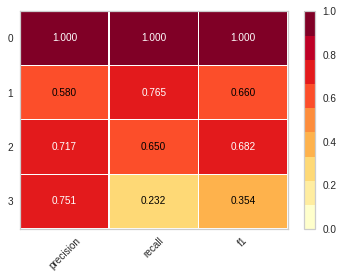

In [ ]:
# RF model

#Create an object of GaussianNB
random_forest = RandomForestClassifier(criterion="entropy", max_depth=3, random_state=42)
#train the algorithm on taining data and predict using the testing data
#Fitting the data
random_forest.fit(x_train,y_train)
#prediction 
pred = random_forest.predict(x_test)
print(pred)

#print the accuracy score
# print("Random Forest Accuracy ",accuracy_score(y_test,pred,normalize = True))
rfc_cv_score = cross_val_score(random_forest, x, y, cv=10, scoring= 'accuracy')
print("RandomForest (10 fold cross validation accuracy): ", rfc_cv_score.mean())

#Confusion Matrix
print(confusion_matrix(y_test,pred))

# Instantiate the classification model and visualizer
visualizer = ClassificationReport(random_forest, classes=['0','1','2','3'])
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data

[3 3 2 ... 1 3 2]
DecisionTree (10 fold cross validation accuracy):  0.7382749604365554
[[ 841   14   82    0]
 [ 155 1889  182    0]
 [ 534  954 1191    0]
 [   0    0    0 2736]]


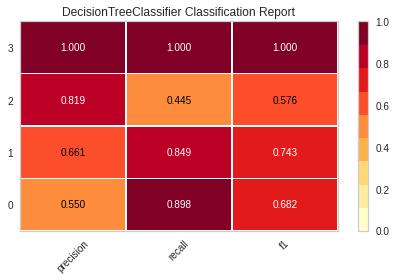

[Text(0.53125, 0.9166666666666666, 'X[5] <= 19253.5\nentropy = 1.911\nsamples = 20013\nvalue = [2280, 5148, 6321, 6264]'),
 Text(0.5, 0.75, 'X[4] <= 0.5\nentropy = 1.476\nsamples = 13749\nvalue = [2280, 5148, 6321, 0]'),
 Text(0.25, 0.5833333333333334, 'X[18] <= 0.5\nentropy = 1.038\nsamples = 8887\nvalue = [41, 4353, 4493, 0]'),
 Text(0.125, 0.4166666666666667, 'X[17] <= 0.5\nentropy = 1.026\nsamples = 7805\nvalue = [34, 4337, 3434, 0]'),
 Text(0.0625, 0.25, 'X[19] <= 0.5\nentropy = 0.974\nsamples = 6859\nvalue = [15, 4284, 2560, 0]'),
 Text(0.03125, 0.08333333333333333, 'entropy = 0.944\nsamples = 6483\nvalue = [15, 4284, 2184, 0]'),
 Text(0.09375, 0.08333333333333333, 'entropy = 0.0\nsamples = 376\nvalue = [0, 0, 376, 0]'),
 Text(0.1875, 0.25, 'X[5] <= 10668.0\nentropy = 0.452\nsamples = 946\nvalue = [19, 53, 874, 0]'),
 Text(0.15625, 0.08333333333333333, 'entropy = 0.624\nsamples = 489\nvalue = [9, 53, 427, 0]'),
 Text(0.21875, 0.08333333333333333, 'entropy = 0.152\nsamples = 457\n

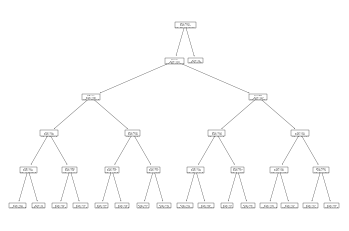

In [ ]:
# Decision Tree
dec_tree = DecisionTreeClassifier(criterion="entropy", max_depth=5)
#train the algorithm on taining data and predict using the testing data
#Fitting the data
dec_tree.fit(x_train,y_train)
#prediction 
pred = dec_tree.predict(x_test)
print(pred)

#print the accuracy score
#print("Decision Tree Accuracy ",accuracy_score(y_test,pred,normalize = True))
dec_tree_cv_score = cross_val_score(dec_tree, x, y, cv=10, scoring= 'accuracy')
print("DecisionTree (10 fold cross validation accuracy): ", dec_tree_cv_score.mean())

#Confusion Matrix
print(confusion_matrix(y_test,pred))

# Instantiate the classification model and visualizer
visualizer = ClassificationReport(dec_tree, classes=['0','1','2','3'])
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

tree.plot_tree(dec_tree)

[3 3 1 ... 1 3 2]
K-Nearest Neighbors (10 fold cross validation accuracy):  0.6249497476989607


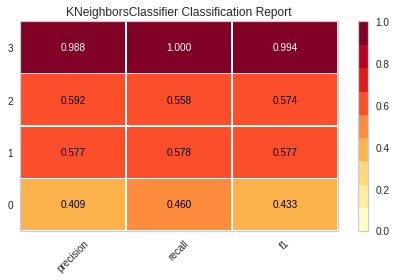

In [ ]:
# KNN (K-Nearest Neighbors)

logmodel=KNeighborsClassifier()
logmodel.fit(x_train,y_train)
y_pred=logmodel.predict(x_test)
print(y_pred)

#print the accuracy score
#print("K-Nearest Neighbors Accuracy",accuracy_score(y_test,y_pred,normalize = True))

knn_cv_score = cross_val_score(logmodel, x, y, cv=10, scoring= 'accuracy')
print("K-Nearest Neighbors (10 fold cross validation accuracy): ", knn_cv_score.mean())

#code for confusion matrix
confusion_matrix(y_test,y_pred)

# Instantiate the classification model and visualizer
visualizer = ClassificationReport(logmodel, classes=['0','1','2','3'])
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data